# Task

1. **Text preprocessing**
  
  a. There are several extra data resources for this competition. You may investigate them also. The most frequently used are the base data and the translated data. Some pre-trained models are also available in Kaggle “public datasets”.

  b. For some models preprocessing may be needed. Please, perform at least the following steps (in preferred order):

     -  Stop-words removing

     -  Processing of numbers and service characters

     -  Register processing

     -  Text normalisation

     -  Dictionary-based processing of informal speech

2. **Embeddings with any preferred classification model** (mandatory are in cursive)

  a. *tf-idf (start with this),*

  b. *word2vec from gensim or spacy,*

  c. fasttext from its native lib or from gensim,

  d. doc2vec from gensim,

  e. Starspace,

  f. *pre-trained BERT in preferred framework*,

  g. *Fine-tune preferred language model*,

  h. Use an ensemble of all models used.

3. **Metric: ROC_AUC**


**Notes:**

All embeddings may be used with pre-trained weights or vectors

You are not limited with the models described above – you can utilise all the models listed in the materials

Check the baseline and beat the score of 0.91

# Preluminaries

В данном ноутбуке представлена модель нейронки c pre-trained embedding Glove. Архитектура нейронки самая простая. В качестве pre-trained embeddings [взято](https://github.com/dcferreira/multilingual-joint-embeddings).

В архиве представлены эмбеддинги для каждого из языков отдельно. Они не особо большие: от 40 до 72 тыс слов в каждом, что не могло не отразится на точности предсказания.

Вектора слов, которые не находились в эмбеддингах, заполнялись нулями. Впоследствии модель дообучалась на уже имеющемся массиве.

Чтобы избежать смещения из-за повторяяющихся слов в близких языках, для кажлого языка строилась отдельная модель. А потом на этапе inference все модели сводились воедино.

Причем, предсказание делалось следующим образом: сначала test разбивался на языки. А потом внутри каждого языка бачами делалось предсказание. В конце, исходная таблица "воссоздавалась" заново, но уже с новым столбцом target.

Все это было сделано для сокращения времени предсказывания.

# Imports

In [ ]:
!pip install unidecode

     |████████████████████████████████| 245kB 8.4MB/s 


In [ ]:
!pip install pyspellchecker

     |████████████████████████████████| 2.7MB 8.7MB/s 


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
#basic package
import numpy as np
import pandas as pd

#nlp
import re
import nltk
import string

#feature engineering
from gensim import utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

#NN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping

#vizualiazation
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'

#settings
import os
import gc
from tqdm import tqdm
plt.rcParams['figure.figsize'] = 10, 8
import warnings 
warnings.filterwarnings('ignore')

#no_random
from numpy.random import seed
seed(1)
tf.random.set_seed(42)

#downloads
import pickle
from google_drive_downloader import GoogleDriveDownloader as gdd

# Auxilliary functions

In [ ]:
def lst_to_str(lst):
    '''
    Функция для перевода списка в строку
    lst - список на вход
    st - строка на выход
    '''
    st = ''
    for element in lst:
         st += element

    return st

In [ ]:
def making_predictions(df, vec, model):
    '''
    Функция для определения токсичности комментария
    df - таблица
    vec - векторайзер
    model - имя модели
    '''
    X = df.comment_text.values
    X = vec(np.array([[s] for s in X])).numpy()

    # вычислим вероятности токсичности комментариев
    probabilities = model.predict(X)
    probabilities = np.around(probabilities.T).T

    # добавим столбец в нашу таблицу
    df['target'] = probabilities
    return df

# Test Data download & some preparations

In [ ]:
gdd.download_file_from_google_drive(file_id='19GL4B5TVJX44K2Hibj7YYCNcLpDwTcx3',\
                                    dest_path='/Data/test.csv')
test = pd.read_csv('/Data/test.csv')
test = test[['comment_text', 'lang']]

In [ ]:
test.head(5)

,comment_text,lang
0,['doctor who adlı viki başlığına doctor olarak...,tr
1,['вполне возможно пока видеть необходимость вы...,ru
2,"['conservativi preferiscono cancellare', 'ok l...",it
3,['malesef gerçekleştirilmedi ancak şöyle şey v...,tr
4,['resim seldabagcan jpg resminde kaynak sorunu...,tr


In [ ]:
%%time
test['comment_text'] = test['comment_text'].apply(lambda row: eval(row))

CPU times: user 1.1 s, sys: 61.6 ms, total: 1.16 s
Wall time: 1.17 s


In [ ]:
%%time
test['comment_text'] = test['comment_text'].apply(lambda row: lst_to_str(row))

CPU times: user 110 ms, sys: 2.91 ms, total: 113 ms
Wall time: 114 ms


# EDA & Data Preparation

Разведочный анализ и чистка данных (train, validation, test) была проведена ранее, при подготовке первой части дз

[EDA и DP вот здесь](https://colab.research.google.com/drive/1RUvUuLHinTWeSZcpzQZlilaSCFGCprpC#scrollTo=7_qOSPhWjPhh)

# Download vectorizers and models & make predictions

Загрузим векторайзер, модель для каждого языка и сделаем предсказание.

[Модель для французского языка](https://colab.research.google.com/drive/1v_efJw9w7JoCTRD7Hxw6LjtzQrA6TFJi?usp=sharing)

In [ ]:
gdd.download_file_from_google_drive(file_id='1g3DiJOPF428gy8yfEKD--rKMspIUEOZG',\
                                    dest_path='/Data/Glove_data/tv_fr.pkl')
from_disk = pickle.load(open("/Data/Glove_data/tv_fr.pkl", "rb"))

vec  = TextVectorization.from_config(from_disk['config'])
vec.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
vec.set_weights(from_disk['weights'])

# загрузим саму модель
gdd.download_file_from_google_drive(file_id='11twMTnUi8TOFcVzf7CHq1MpR6q6AwkLE',\
                                    dest_path='/Data/Glove_data/model_fr.h5')
model = tf.keras.models.load_model('/Data/Glove_data/model_fr.h5')


test_fr = test[test.lang == 'fr'].reset_index()
test_fr = making_predictions(test_fr, vec, model)

In [ ]:
pred = test_fr

In [ ]:
del test_fr
gc.collect()

8220

[Модель для иcпанского языка](https://colab.research.google.com/drive/1ucSqX6NwFr1fvyy0-w7WbxzJbHug3B_v?usp=sharing)

In [ ]:
gdd.download_file_from_google_drive(file_id='1aS5wwmrvKqCdjgrmxilyb97zqYglgJmP',\
                                    dest_path='/Data/Glove_data/tv_es.pkl')
from_disk = pickle.load(open("/Data/Glove_data/tv_es.pkl", "rb"))

vec  = TextVectorization.from_config(from_disk['config'])
vec.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
vec.set_weights(from_disk['weights'])

# загрузим саму модель
gdd.download_file_from_google_drive(file_id='1fATBwGrobJGOTOCTeq60kdknPFJoXS-o',\
                                    dest_path='/Data/Glove_data/model_es.h5')
model = tf.keras.models.load_model('/Data/Glove_data/model_es.h5')

test_es = test[test.lang == 'es'].reset_index()
test_es = making_predictions(test_es, vec, model)

In [ ]:
pred = pd.concat([pred, test_es], ignore_index=False)

In [ ]:
del test_es
gc.collect()

56326

[Модель для итальянского языка](https://colab.research.google.com/drive/1qrHWihQE_A2AYcTMZ_fyosOOph9ZJqlN?usp=sharing)

In [ ]:
gdd.download_file_from_google_drive(file_id='1ikPElljbL7ygFBUoBaE8N5gSZaJC0DZv',\
                                    dest_path='/Data/Glove_data/tv_it.pkl')
from_disk = pickle.load(open("/Data/Glove_data/tv_it.pkl", "rb"))

vec  = TextVectorization.from_config(from_disk['config'])
vec.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
vec.set_weights(from_disk['weights'])

# загрузим саму модель
gdd.download_file_from_google_drive(file_id='15me_ry4QsU7GDZ4ebUKxFzlvTPGyA4eO',\
                                    dest_path='/Data/Glove_data/model_it.h5')
model = tf.keras.models.load_model('/Data/Glove_data/model_it.h5')

test_it = test[test.lang == 'it'].reset_index()
test_it = making_predictions(test_it, vec, model)

In [ ]:
pred = pd.concat([pred, test_it], ignore_index=False)

In [ ]:
del test_it
gc.collect()

57828

[Модель для португальского языка](https://colab.research.google.com/drive/10uPBXoFSboOwANQTd5tP-wEFQD3iwcAf?usp=sharing)

In [ ]:
gdd.download_file_from_google_drive(file_id='1cnQVXPBaGYM591CSOEYAJ83pJKUQf9zR',\
                                    dest_path='/Data/Glove_data/tv_pt.pkl')
from_disk = pickle.load(open("/Data/Glove_data/tv_pt.pkl", "rb"))

vec  = TextVectorization.from_config(from_disk['config'])
vec.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
vec.set_weights(from_disk['weights'])

# загрузим саму модель
gdd.download_file_from_google_drive(file_id='1Ylq31seDJcAvyTwUlpyyCNKLCOg1eDaI',\
                                    dest_path='/Data/Glove_data/model_pt.h5')
model = tf.keras.models.load_model('/Data/Glove_data/model_pt.h5')

test_pt = test[test.lang == 'pt'].reset_index()
test_pt = making_predictions(test_pt, vec, model)

In [ ]:
pred = pd.concat([pred, test_pt], ignore_index=False)

In [ ]:
del test_pt
gc.collect()

45772

[Модель для русского языка](https://colab.research.google.com/drive/1R-WuoloqsmN3Ig5A36jOXDocdvsi27KE#scrollTo=P79WUoKLvtND)

In [ ]:
# загрузим векторизатор
gdd.download_file_from_google_drive(file_id='1PgLEb8_S1KdPGtdy2DJmWRZE8XVAYFJg',\
                                    dest_path='/Data/Glove_data/tv_ru.pkl')
from_disk = pickle.load(open("/Data/Glove_data/tv_ru.pkl", "rb"))

vec  = TextVectorization.from_config(from_disk['config'])
vec.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
vec.set_weights(from_disk['weights'])

# загрузим саму модель
gdd.download_file_from_google_drive(file_id='1izbR58zSlhI6AYSuoMl3mKCJvL5IoLYc',\
                                    dest_path='/Data/Glove_data/model_ru.h5')
model = tf.keras.models.load_model('/Data/Glove_data/model_ru.h5')

test_ru = test[test.lang == 'ru'].reset_index()
test_ru = making_predictions(test_ru, vec, model)

In [ ]:
pred = pd.concat([pred, test_ru], ignore_index=False)

In [ ]:
del test_ru
gc.collect()

46195

[Модель для турецкого языка](https://colab.research.google.com/drive/1qzFVXtw_XnMJy0fT7NQyseemvvdlgKRN#scrollTo=PQLMk3s6b4zJ)

In [ ]:
# загрузим векторизатор
gdd.download_file_from_google_drive(file_id='1OYArfb962DH74McxenS9E4Sq9k9eS7gY',\
                                    dest_path='/Data/Glove_data/tv_tr.pkl')
from_disk = pickle.load(open("/Data/Glove_data/tv_tr.pkl", "rb"))

vec  = TextVectorization.from_config(from_disk['config'])
vec.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
vec.set_weights(from_disk['weights'])

# загрузим саму модель
gdd.download_file_from_google_drive(file_id='1NtYG6li7a8jPohGBntJUrSCHDfDbqasQ',\
                                    dest_path='/Data/Glove_data/model_tr.h5')
model = tf.keras.models.load_model('/Data/Glove_data/model_tr.h5')

test_tr = test[test.lang == 'tr'].reset_index()
test_tr = making_predictions(test_tr, vec, model)

In [ ]:
pred = pd.concat([pred, test_tr], ignore_index=False)

In [ ]:
pred['target']=pred.target.apply(lambda row: int(row))

In [ ]:
del test_tr, test
gc.collect()

56032

In [ ]:
pred

,index,comment_text,lang,target
0,5,truc plus important tirade avis coté encyclopé...,fr,1
1,12,surtout sacré dévot cabotin idiot mythomane as...,fr,1
2,13,contributeur tente prouver absurde commentaire...,fr,0
3,16,propos léon langage sauvage discours calomnian...,fr,0
4,19,prendsoses dire comporte bébé ansdéjà dis impo...,fr,0
...,...,...,...,...
13995,63781,dünyayı güzellik kurtaracak insanı sevmekle ba...,tr,0
13996,63791,önemli değilpostyorum tam bilgi kutusu ekledim...,tr,0
13997,63802,ckallogo jpg lisans sorunu px left dosya telif...,tr,0
13998,63806,evet haklısın telifli etiketi koymuşsun demişi...,tr,0


Отсортируем по старым индексам. И посмотрим, что у нас получилось

In [ ]:
pred = pred.sort_values(by=['index'])

In [ ]:
pred = pred.set_index('index')

In [ ]:
predictions = pred.target

In [ ]:
predictions

index
0        0
1        0
2        0
3        0
4        0
        ..
63807    1
63808    0
63809    0
63810    0
63811    0
Name: target, Length: 63812, dtype: int64

#Submission

In [ ]:
def save_submission(pred):
    pd.Series(
        pred, name='toxic', index=pd.Index(range(len(pred)), name='id')
    ).to_csv('notebook_submission_glove.csv')

In [ ]:
save_submission(predictions)

И что же кэгль?

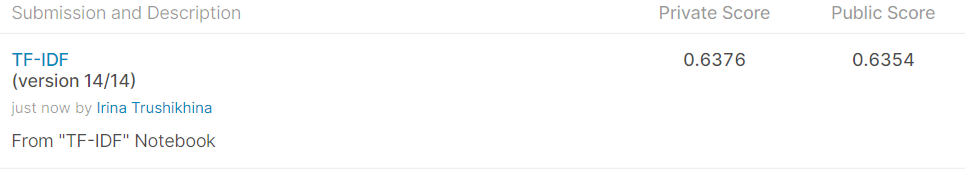

Это не Tf-idf - я просто все в версии одного блокнота забиваю

# Выводы:

Результаты ожидаемы. У нас informal speech. А мы делали все по заранее pre-trained embeddings. Очевидно, не все слова нашлись. Отсюда результаты + очень незатейливая архитектура нейронки.

Glove отработал лучше на более стабильных языках, и плохо на морфологически богатых.

В дальнейшем, при работе с такими языками, особенно с русским, лучше работать с FastText. Ну и делать лемматизацию заодно.